8277 samples in the final test set.
percentage of vulnerable samples: 8.98%
absolute amount of vulnerable samples in test set: 744
259/259 [==============================] - 29s 106ms/step
Accuracy-BiLSTM: 0.9919052796907092
Precision-BiLSTM: 0.9643347050754458
Recall-BiLSTM: 0.9448924731182796
F1 score-BiLSTM: 0.954515


259/259 [==============================] - 28s 107ms/step
0.9970096628597611


c:\Users\ginoc\OneDrive\Documents\Facultad\Tesina\VulDetFarPos\.FarPos-venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator LogisticRegression from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy-LR: 0.979461
Precision-LR: 0.912356
Recall-LR: 0.853495
F1 score-LR: 0.881944
[0.        0.        0.        ... 0.9992035 0.9997345 1.       ]


c:\Users\ginoc\OneDrive\Documents\Facultad\Tesina\VulDetFarPos\.FarPos-venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator GaussianNB from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy-GNB: 0.091942
Precision-GNB: 0.090073
Recall-GNB: 1.000000
F1 score-GNB: 0.165260
[0.         0.99774326 1.        ]


c:\Users\ginoc\OneDrive\Documents\Facultad\Tesina\VulDetFarPos\.FarPos-venv\lib\site-packages\sklearn\base.py:348: InconsistentVersionWarning: Trying to unpickle estimator DecisionTreeClassifier from version 1.3.0 when using version 1.3.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


Accuracy-tree: 0.915549
Precision-tree: 0.695652
Recall-tree: 0.107527
F1 score-tree: 0.186263


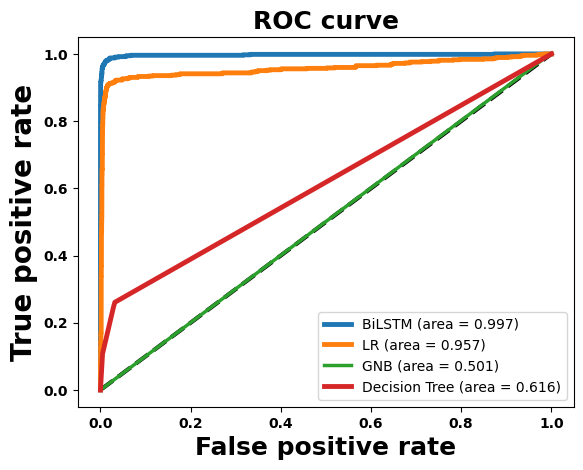

In [9]:
import myutils
from datetime import datetime
import sys
import os
import pickle
from keras.models import load_model
from gensim.models import Word2Vec, KeyedVectors
from keras.preprocessing import sequence
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
import tensorflow as tf
import numpy

from sklearn.metrics import roc_curve
from sklearn.metrics import auc
import matplotlib.pyplot as plt


#default mode / type of vulnerability
mode = "xss"

#get the vulnerability from the command line argument
if (len(sys.argv) > 1):
  mode = sys.argv[1]

model = load_model('Model-BiLSTM/Bidirectional_LSTM_model_xss.h5',custom_objects={'f1_loss': myutils.f1_loss, 'f1':myutils.f1})
  

with open('data/xss_dataset_finaltest_X', 'rb') as fp:
  FinaltestX = pickle.load(fp)
with open('data/xss_dataset_finaltest_Y', 'rb') as fp:
  FinaltestY = pickle.load(fp)


now = datetime.now() # current date and time
nowformat = now.strftime("%H:%M")

#Prepare the data for the LSTM model


y_finaltest =  numpy.array(FinaltestY, dtype="object")
X_finaltest =  numpy.array(FinaltestX, dtype="object")

#in the original collection of data, the 0 and 1 were used the other way round, so now they are switched so that "1" means vulnerable and "0" means clean.
    
for i in range(len(y_finaltest)):
  if y_finaltest[i] == 0:
    y_finaltest[i] = 1
  else:
    y_finaltest[i] = 0


now = datetime.now() # current date and time
nowformat = now.strftime("%H:%M")

print(str(len(X_finaltest)) + " samples in the final test set.")
  
  
csum = 0
for y in y_finaltest:
  csum = csum+y

print("percentage of vulnerable samples: "  + str(int((csum / len(X_finaltest)) * 10000)/100) + "%")
print("absolute amount of vulnerable samples in test set: " + str(csum))

#padding sequences on the same length
max_length = 200   
X_finaltest = sequence.pad_sequences(X_finaltest, maxlen=max_length)

X_finaltest = numpy.asarray(X_finaltest).astype(numpy.float32)
y_finaltest= numpy.asarray(y_finaltest).astype(numpy.float32)     
      
yhat_classes = (model.predict(X_finaltest) > 0.5).astype("int32")
accuracy = accuracy_score(y_finaltest, yhat_classes)
precision = precision_score(y_finaltest, yhat_classes)
recall = recall_score(y_finaltest, yhat_classes)
F1Score = f1_score(y_finaltest, yhat_classes)
  
print("Accuracy-BiLSTM: " + str(accuracy))
print("Precision-BiLSTM: " + str(precision))
print("Recall-BiLSTM: " + str(recall))
print('F1 score-BiLSTM: %f' % F1Score)
print("\n")




#lstmauc
y_pred_lstm = model.predict(X_finaltest).ravel()
fpr_lstm, tpr_lstm, thresholds_lstm = roc_curve(y_finaltest, y_pred_lstm)
auc_lstm = auc(fpr_lstm, tpr_lstm)
print (auc_lstm)



#setshape
nsamples, nx, ny = X_finaltest.shape
X_finaltest = X_finaltest.reshape((nsamples,nx*ny))



#load-LR
import pickle
pickled_model = pickle.load(open('Model-others/xss-LR.pkl', 'rb'))
lg_probs = pickled_model.predict(X_finaltest)
accuracylg = accuracy_score(y_finaltest, lg_probs)
print('Accuracy-LR: %f' % accuracylg)
# precision tp / (tp + fp)
precisionlg = precision_score(y_finaltest, lg_probs)
print('Precision-LR: %f' % precisionlg)
# recall: tp / (tp + fn)
recalllg = recall_score(y_finaltest, lg_probs)
print('Recall-LR: %f' % recalllg)
# f1: 2 tp / (2 tp + fp + fn)
f1lg = f1_score(y_finaltest, lg_probs)
print('F1 score-LR: %f' % f1lg)

#auc-LR
y_pred_lr = pickled_model.predict_proba(X_finaltest)[:, 1]
fpr_lr, tpr_lr, thresholds_lr = roc_curve(y_finaltest, y_pred_lr)
auc_lr = auc(fpr_lr, tpr_lr)
print (fpr_lr)


#load-GNB
pickled_model2 = pickle.load(open('Model-others/xss-GNB.pkl', 'rb'))
G_probs = pickled_model2.predict(X_finaltest)
accuracyGNB = accuracy_score(y_finaltest, G_probs)
print('Accuracy-GNB: %f' % accuracyGNB)
# precision tp / (tp + fp)
precisionGNB = precision_score(y_finaltest, G_probs)
print('Precision-GNB: %f' % precisionGNB)
# recall: tp / (tp + fn)
recallGNB = recall_score(y_finaltest, G_probs)
print('Recall-GNB: %f' % recallGNB)
# f1: 2 tp / (2 tp + fp + fn)
f1GNB = f1_score(y_finaltest, G_probs)
print('F1 score-GNB: %f' % f1GNB)   



#auc-GNB
y_pred_GNB = pickled_model2.predict_proba(X_finaltest)[:, 1]
fpr_gnb, tpr_gnb, thresholds_gnb = roc_curve(y_finaltest, y_pred_GNB)
auc_gnb = auc(fpr_gnb, tpr_gnb)
print (fpr_gnb)




#load-MLP
#pickled_model3 = pickle.load(open('xss-MLP.pkl', 'rb'))
#m_probs = pickled_model3.predict(X_finaltest)
#accuracymlp = accuracy_score(y_finaltest, m_probs)
#print('Accuracy-MLP: %f' % accuracymlp)
## precision tp / (tp + fp)
#precisionmlp = precision_score(y_finaltest, m_probs)
#print('Precision-MLP: %f' % precisionmlp)
## recall: tp / (tp + fn)
#recallmlp = recall_score(y_finaltest, m_probs)
#print('Recall-MLP: %f' % recallmlp)
## f1: 2 tp / (2 tp + fp + fn)
#f1mlp = f1_score(y_finaltest, m_probs)
#print('F1 score-MLP: %f' % f1mlp)  
#
##auc-MLP
#y_pred_mlp = pickled_model3.predict_proba(X_finaltest)[:, 1]
#fpr_mlp, tpr_mlp, thresholds_mlp = roc_curve(y_finaltest, y_pred_mlp)
#auc_mlp = auc(fpr_mlp, tpr_mlp)
#print (fpr_mlp)


#load-TREE
pickled_model4 = pickle.load(open('Model-others/xss-TREE.pkl', 'rb'))
treehat_probs = pickled_model4.predict(X_finaltest)
accuracy = accuracy_score(y_finaltest, treehat_probs)
print('Accuracy-tree: %f' % accuracy)
# precision tp / (tp + fp)
precision = precision_score(y_finaltest, treehat_probs)
print('Precision-tree: %f' % precision)
# recall: tp / (tp + fn)
recall = recall_score(y_finaltest, treehat_probs)
print('Recall-tree: %f' % recall)
# f1: 2 tp / (2 tp + fp + fn)
f1 = f1_score(y_finaltest, treehat_probs)
print('F1 score-tree: %f' % f1)




#auc-TREE
probs = pickled_model4.predict_proba(X_finaltest)
probs = probs[:, 1]
fpr, tpr, thresholds = roc_curve(y_finaltest, probs)
auc_tree = auc(fpr,tpr)





#ploting F-score
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', linewidth=3.0)
plt.plot(fpr_lstm, tpr_lstm, label='BiLSTM (area = {:.3f})'.format(auc_lstm), linewidth=3.5)
plt.plot(fpr_lr, tpr_lr, label='LR (area = {:.3f})'.format(auc_lr), linewidth=3.5)
plt.plot(fpr_gnb, tpr_gnb, label='GNB (area = {:.3f})'.format(auc_gnb), linewidth=2.5)
#plt.plot(fpr_mlp, tpr_mlp, label='MLP (area = {:.3f})'.format(auc_mlp), linewidth=3.5)
plt.plot(fpr, tpr, label='Decision Tree (area = {:.3f})'.format(auc_tree), linewidth=3.5)

plt.xlabel('False positive rate', fontsize=18, weight = 'bold')
plt.ylabel('True positive rate', fontsize=20, weight = 'bold')
plt.title('ROC curve',fontsize=18, weight = 'bold')
plt.legend(loc='best')
plt.xticks(weight = 'bold')
plt.yticks(weight = 'bold')
plt.show()
